# Importing Dependencies and Downloading Augmented Images and Augmented Images Dataframe

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sea

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import cv2

import random
import math
import os
from os.path import exists
from datetime import datetime

In [ ]:
from keras import Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Lambda, ELU, ReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers


In [ ]:
TEST = '_2.10.1'
ARCH = 0

In [ ]:
# Load Augmented Images
!gdown "1RYIzIg3A1JmbczEg5el1CY8LQzoDY0ZI"
!unrar x "./Augmented_Data_2.10.1.rar" -idq


Downloading...
From: https://drive.google.com/uc?id=1RYIzIg3A1JmbczEg5el1CY8LQzoDY0ZI
To: /content/Augmented_Data_2.8.10.rar
100% 228M/228M [00:01<00:00, 166MB/s]

Cannot open ./Augmented_Data_2.8.1.rar
No such file or directory

In [ ]:
# Load Augmented Dataframe
!gdown "1dTiTYtz5gVGF23JNL0brjj0DsDrwA1Rv"

Downloading...
From: https://drive.google.com/uc?id=1dTiTYtz5gVGF23JNL0brjj0DsDrwA1Rv
To: /content/augmented_df_2.8.10.csv
100% 966k/966k [00:00<00:00, 44.1MB/s]


# Data Preprocessing

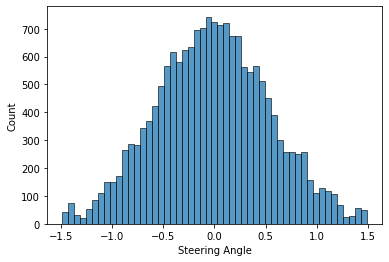

In [ ]:
df_augmented = pd.read_csv(f'augmented_df{TEST}.csv', index_col=0)
df_augmented = df_augmented.sample(frac=1).reset_index(drop=True) # shuffle images

sea.histplot(df_augmented['Steering Angle'])

## Extracting Features and Labels

In [ ]:
image_count = df_augmented.shape[0]
image_path = '/content/' + df_augmented.iloc[0, 0]
image = cv2.imread(image_path)
image = cv2.resize(image , (200, 66))
image_size = image.shape

images = np.zeros((image_count, *image_size)) # creating array to hold images as arrays
angles = np.zeros((image_count)) # creating array to hold angels

print(image.shape, images.shape, angles.shape)

(66, 200, 3) (17220, 66, 200, 3) (17220,)


In [ ]:
for row in range(df_augmented.shape[0]):
    image_path = '/content/' + df_augmented.iloc[row, 0]
    angle = df_augmented.iloc[row, 1]

    image = cv2.imread(image_path)
    image = cv2.resize(image , (200, 66))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if(row % 500 == 0):
        print(image_count - row, ' images left')
        # print('\t', image_path, '    ', angle,'\n')
        

    images[row] = image
    angles[row] = angle

17220  images left
16720  images left
16220  images left
15720  images left
15220  images left
14720  images left
14220  images left
13720  images left
13220  images left
12720  images left
12220  images left
11720  images left
11220  images left
10720  images left
10220  images left
9720  images left
9220  images left
8720  images left
8220  images left
7720  images left
7220  images left
6720  images left
6220  images left
5720  images left
5220  images left
4720  images left
4220  images left
3720  images left
3220  images left
2720  images left
2220  images left
1720  images left
1220  images left
720  images left
220  images left


# CNN Architectures

In [ ]:
def arch_1(height, width, channels):
    global ARCH
    Arch = 1
    model = Sequential()

    model.add(Input(shape=(height, width, channels)))

    model.add(Conv2D(3, (1, 1)))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Conv2D(32, (3, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    
    model.add(Conv2D(128, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))

    model.add(Flatten())
    model.add(Dense(512, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(16, activation='elu'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
  
    return model

In [ ]:
def arch_2(height, width, channels):
    model = Sequential()
    model.add(Input(shape=(height, width, channels)))

    # batch regularization to reduce internal covariate shift
    model.add(BatchNormalization())

    # 200x66x3 -> 98x31x24, 5x5 convolution
    model.add(Conv2D(3, (1, 1)))
    model.add(Conv2D(24, (5, 5)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 98x31x24 -> 47x14x36, 5x5 convolution
    model.add(Conv2D(36, (5, 5)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 47x14x36 -> 22x5x48, 5x5 convolution
    model.add(Conv2D(48, (5, 5)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 22x5x48 -> 20x3x64, 3x3 convolution
    model.add(Conv2D(64, (3, 3)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))

    # 20x3x64 -> 18x1x64, 3x3 convolution
    model.add(Conv2D(64, (3, 3)))
    model.add(ELU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))

    # flatten
    model.add(Flatten())

    # dense 1164
    model.add(Dense(1164))
    model.add(ELU())
    model.add(Dropout(0.5))

    # dense 100
    model.add(Dense(100))
    model.add(ELU())

    # dense 50
    model.add(Dense(50))

    # dense 10
    model.add(Dense(10))

    # dense 1
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

In [ ]:
def arch_3(height, width, channels):
    model = Sequential()

    model.add(Input(shape=(height, width, channels)))
    
    model.add(Conv2D(3, (5, 5)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(24, (5, 5)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(36, (5, 5)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(48, (3, 3)))
    model.add(ELU(alpha=1.0))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(64, (3, 3)))
    model.add(ELU(alpha=1.0))

    model.add(Flatten())

    model.add(Dense(1164, activation='elu'))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
  
    return model

In [ ]:
def arch_4 (height, width, channels):
    model = Sequential()
    model.add(Input(shape=(height, width, channels)))
    model.add(Conv2D(24, kernel_size=(5, 5) ,activation='elu'))
    model.add(Conv2D(36, kernel_size=(5, 5) ,activation='elu'))
    model.add(Conv2D(48, kernel_size=(5, 5),activation='elu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
  
    return model

In [ ]:
def arch_5(height, width, channels):
    ARCH = 5

    model = Sequential()

    model.add(Input(shape=(height, width, channels)))

    model.add(Conv2D(3, (1, 1)))
    model.add(Conv2D(3, 5, padding="SAME", strides=(2,2)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(24, 5, padding="SAME", strides=(2,2)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(36, 5, padding="SAME", strides=(2,2)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(48, 3, padding="SAME", strides=(1,1)))
    model.add(ELU(alpha=1.0))

    model.add(Conv2D(64, 3, padding="SAME", strides=(1,1)))
    model.add(ELU(alpha=1.0))

    model.add(Flatten())

    model.add(Dense(1164))
    model.add(Dropout(0.5))

    model.add(Dense(100))
    model.add(Dropout(0.5))

    model.add(Dense(50))
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Dropout(0.5))

    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
    return model

In [ ]:
def arch_6(height, width, channels):
    ARCH = 6
    model = Sequential()

    model.add(Input(shape=(height, width, channels)))

    model.add(Conv2D(3, (1, 1)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Conv2D(32, (3, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    model.add(Dropout(0.6))

    model.add(Conv2D(32, (1, 1)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Conv2D(64, (3, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    model.add(Dropout(0.6))
    
    model.add(Conv2D(64, (1, 1)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Conv2D(128, (3, 3)))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization())
    model.add(ELU(alpha=1.0))
    model.add(Dropout(0.6))

    model.add(Flatten())
    model.add(Dense(512, activation='elu'))
    model.add(Dropout(0.6))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.6))
    model.add(Dense(16, activation='elu'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
  
    return model

In [ ]:
def arch_7(height, width, channels):
    ARCH = 7
    model = Sequential()

    model.add(Input(shape=(height, width, channels)))

    model.add(Conv2D(3, (1, 1), padding="SAME"))
    model.add(Conv2D(32, (3, 3), padding="SAME"))
    model.add(Conv2D(32, (3, 3), padding="SAME"))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization(axis=1))
    model.add(ReLU())

    model.add(Conv2D(32, (1, 1), padding="SAME"))
    model.add(Conv2D(64, (3, 3), padding="SAME"))
    model.add(Conv2D(64, (3, 3), padding="SAME"))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization(axis=1))
    model.add(ReLU())
    
    model.add(Conv2D(128, (3, 3), padding="SAME"))
    model.add(Conv2D(128, (3, 3), padding="SAME"))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization(axis=1))
    model.add(ReLU())
    
    model.add(Conv2D(516, (3, 3), padding="SAME"))
    model.add(Conv2D(516, (3, 3), padding="SAME"))
    model.add(MaxPooling2D((2,2)))
    model.add(BatchNormalization(axis=1))
    model.add(ReLU())

    model.add(Flatten())
    model.add(Dense(512, activation='ReLU'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='ReLU'))
    model.add(Dropout(0.4))
    model.add(Dense(16, activation='ReLU'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
  
    return model

In [ ]:
def arch_8(height, width, channels):
    global ARCH
    Arch = 8
    
    model = Sequential()

    model.add(Input(shape=(height, width, channels)))

    model.add(Conv2D(3, (1, 1), padding="SAME"))
    model.add(Conv2D(32, (3, 3), padding="SAME"))
    model.add(Conv2D(32, (3, 3), padding="SAME"))
    model.add(MaxPooling2D((2,2)))
    model.add(ReLU())

    model.add(Conv2D(64, (3, 3), padding="SAME"))
    model.add(Conv2D(64, (3, 3), padding="SAME"))
    model.add(MaxPooling2D((2,2)))
    model.add(ReLU())
    
    model.add(Conv2D(128, (3, 3), padding="SAME"))
    model.add(Conv2D(128, (3, 3), padding="SAME"))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.7))
    model.add(ReLU())

    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(16, activation='elu'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")
  
    return model

In [ ]:
def arch_9(h, w, c):
    global ARCH
    ARCH = 9

    model = Sequential()

    # batch regularization to reduce internal covariate shift
    model.add(Input(shape=(h, w, c))) # wc ... lol
    model.add(BatchNormalization())

    # 200x66x3 -> 98x31x24, 5x5 convolution
    model.add(Conv2D(24, 5))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 98x31x24 -> 47x14x36, 5x5 convolution
    model.add(Conv2D(36, 5))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 47x14x36 -> 22x5x48, 5x5 convolution
    model.add(Conv2D(48, 5))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 22x5x48 -> 20x3x64, 3x3 convolution
    model.add(Conv2D(64, 3))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))

    # 20x3x64 -> 18x1x64, 3x3 convolution
    model.add(Conv2D(64, 3))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))

    # flatten
    model.add(Flatten())

    # dense 1164
    model.add(Dense(1164))
    model.add(ReLU())
    model.add(Dropout(0.5))

    # dense 100
    model.add(Dense(100))
    model.add(ReLU())

    # dense 50
    model.add(Dense(50))

    # dense 10
    model.add(Dense(10))

    # dense 1
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

In [ ]:
def arch_10(h, w, c):
    global ARCH
    ARCH = 9

    model = Sequential()

    # batch regularization to reduce internal covariate shift
    model.add(Input(shape=(h, w, c))) # wc ... lol
    model.add(BatchNormalization())

    # 200x66x3 -> 98x31x24, 5x5 convolution
    model.add(Conv2D(24, 5))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 98x31x24 -> 47x14x36, 5x5 convolution
    model.add(Conv2D(36, 5))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 47x14x36 -> 22x5x48, 5x5 convolution
    model.add(Conv2D(48, 5))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"))

    # 22x5x48 -> 20x3x64, 3x3 convolution
    model.add(Conv2D(64, 3))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))

    # 20x3x64 -> 18x1x64, 3x3 convolution
    model.add(Conv2D(64, 3))
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
    model.add(BatchNormalization())

    # flatten
    model.add(Flatten())

    # dense 1164
    model.add(Dense(1164))
    model.add(ReLU())
    model.add(Dropout(0.5))

    # dense 100
    model.add(Dense(100))
    model.add(ReLU())

    # dense 50
    model.add(Dense(50))

    # dense 10
    model.add(Dense(10))

    # dense 1
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

## Training the Model

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='min')
checkpoint = ModelCheckpoint('./ModelCheckpoint/' + '-{epoch:02d}-{val_loss:.4f}', monitor='val_loss',verbose=0, save_best_only=True, save_weights_only=False, mode='auto')

callbacks = [
checkpoint
]

In [ ]:
class saveWeights(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        ARCH = 9
        val_loss = logs.get('val_loss')
        now = datetime.now()
        current_time = now.strftime("%d %m %y - %H:%M:%S")
        model.save(f'./Models/model_ARCH-{ARCH}_TEST-{TEST}_VAL-LOSS-{val_loss}.h5')
        print("Model saved")

saveModelWeights = saveWeights()

In [ ]:
# Compile Model
arch = arch_9
model = arch(*image_size)

# Features and Labels
x = images
y = angles

# train model
model.fit(
    x, 
    y,
    epochs = 10,
    verbose = 1,
    validation_split = 0.2,
    callbacks=[checkpoint, saveModelWeights]
)

Epoch 1/10
431/431 [==============================] - ETA: 0s - loss: 0.1419INFO:tensorflow:Assets written to: ./ModelCheckpoint/-01-0.1030/assets
Model saved
431/431 [==============================] - 421s 974ms/step - loss: 0.1419 - val_loss: 0.1030
Epoch 2/10
431/431 [==============================] - ETA: 0s - loss: 0.1040INFO:tensorflow:Assets written to: ./ModelCheckpoint/-02-0.0991/assets
Model saved
431/431 [==============================] - 428s 993ms/step - loss: 0.1040 - val_loss: 0.0991
Epoch 3/10
431/431 [==============================] - ETA: 0s - loss: 0.0949INFO:tensorflow:Assets written to: ./ModelCheckpoint/-03-0.0945/assets
Model saved
431/431 [==============================] - 413s 959ms/step - loss: 0.0949 - val_loss: 0.0945
Epoch 4/10
431/431 [==============================] - ETA: 0s - loss: 0.0889INFO:tensorflow:Assets written to: ./ModelCheckpoint/-04-0.0836/assets
Model saved
431/431 [==============================] - 431s 1s/step - loss: 0.0889 - val_loss: 0.

## Saving the model

In [ ]:

# try:
#     now = datetime.now()
#     current_time = now.strftime("%d %m %y - %H:%M:%S")
#     model.save(f'./Models/model_ARCH-{ARCH}_TEST-{TEST}.h5')
#     print("Model saved")
# except Exception as e:
#     print(e)

Model saved


In [ ]:
# from google.colab import files

# try:
#     for filename in os.listdir("/content/Models"):
#         if('h5' in filename):
#             try:
#                 files.download('/content/Models/' + filename)
#             except Exception as e:
#                 print('3.1', e)
# except Exception as e:
#     print('3', e)
#     x = 0
#     while True:
#         x += 0.0001


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Plotting Predictions

In [ ]:
model_test = arch(*image_size)
model_test.load_weights(f'/content/Models/model_ARCH-{ARCH}_TEST-{TEST}.h5')
predictions = np.zeros((images.shape[0]))
for i, image in enumerate(images):
    prediction = model_test.predict(np.reshape(image, (1, *image_size)))
    predictions[i] = prediction
    if( i % 500 == 0):
        print(images.shape[0] - i, ' images left')

In [ ]:
import seaborn as sea

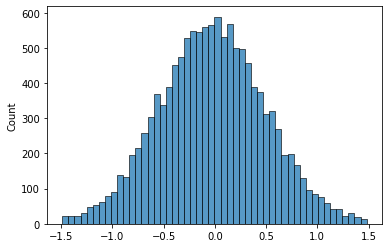

In [ ]:
sea.histplot(angles)

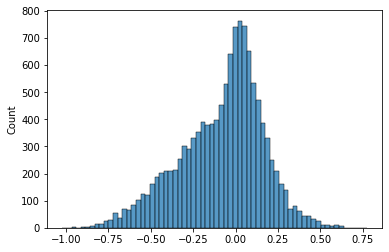

In [ ]:
sea.histplot(predictions)

# Downloading NoteBook

In [ ]:
%%shell
jupyter nbconvert --to html /content/Deep_Learning_Project_Team_7.ipynb

[NbConvertApp] Converting notebook /content/Deep_Learning_Project_Team_7.ipynb to html
[NbConvertApp] Writing 417173 bytes to /content/Deep_Learning_Project_Team_7.html
